
Hexagonal grid(hexgrids) are an useful tool when one is performing spatial analysis in GIS. It is opposed to the ubiquitous square-patterned type of data (Raster, netCDF, etc.), which is more straightforward as the data can be rendered within an image format.

Python is a relatively new tool, allowing the GIS analyst to leverage the power of Python's numerous libraries. These opensource libraries provide numerous tools for scientific calculation, such as statistical [Scikit learn] and spatial analysis library [PySAL](http://pysal.org/pysal/).
As I aim at using the [Tobler](https://pysal.org/notebooks/model/tobler/intro.html) package, which is part of the [PySAL](http://pysal.org/pysal/) library, I would favor doing any calculations of [spatial interpolation](https://docs.qgis.org/2.18/en/docs/gentle_gis_introduction/spatial_analysis_interpolation.html) in a hexgrid pattern. 

Hexgrid pattern offers indeed the same amount of contact length for each of its neighbors, which is not the case with your default pixels. It is then up to the operator to pick a law that is mitigating the influence of corner pixels(nearest neighbor, bilinear interpolation, trilinear interpolation) on the calculation. Since a hexgrid cell is contacting its neighbouring cells by the same amount, calculation results are less tricky to make sense of. Also, there won't be any error generated by decreasing the hexgrid mesh resolution, lowering its cell count in general.
Furthermore, I expect hexgrid to be more robust dealilng with datasources of different resolution for interpolation calculations.

While the [h3fy function](https://pysal.org/tobler/notebooks/census_to_hexgrid.html) from Tobler's package is providing a quick way to creating a hex grid atop of geographical data, I achieved the same functionnality using GeoPandas and [Shapely](https://shapely.readthedocs.io/en/stable/index.html)'s [Voronoi Polygons](https://shapely.readthedocs.io/en/stable/reference/shapely.voronoi_polygons.html) method.

This work is meant to find out pyhton syntax useful to gather data from a PostGIS Database to perform treatment using Python's aforementionned libraries.

Any feedback is appreciated.


# Hexgrid on GIS data

## Setup



In [45]:
import geopandas as gpd
import shapely as shp
import pandas as pd
import matplotlib.pyplot as plt

We're supplying the [database URL](https://docs.sqlalchemy.org/en/20/core/engines.html#database-urls) so wa can setup [SQL Alchemy](https://docs.sqlalchemy.org/en/20/index.html)'s engine. Here, we're using [BD_Topo®](https://geoservices.ign.fr/bdtopo) data from France's IGN®, which is copied on a localhost database for convenience. We could use ["Département 34 - Hérault"](https://geoservices.ign.fr/bdtopo#telechargementshpdept) in particular.
We'll use later on France's official boundaries, with the [Admin Express](https://geoservices.ign.fr/adminexpress) dataset. But I've been importing a dataset from IGN's BD Topo Dataset, which is drawn after the former layer.

In [46]:
layer = gpd.read_file('periphereies/periphereies.shp')

### Of hexgrids

The *a* parameter is the distance separating the centroids of each hex cell. It's our resolution and it's set in the map's units (generally, meters). We're building our hex cells off of their centroid. Hence we are introducing the height *h* betwenn rows so that we'll eventually have an equiditant length between the points we're picking. $$h = \sqrt{a^2 - (a/2)^2} $$

In [47]:
a = 50000 # en mètres !

h = (a**2 - (a/2)**2)**(1/2)

### Mesh constructing with points

Let such a mesh happen within our considered area of interest. We'll define its *bounding box*. Our point mesh is drawn along the units of our Coordinate Reference System (**CRS**). 
First, we're calling GeoPanda's [total_bounds](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html) function, and we're defining our min and max values accordingly.

In [48]:
areaofinterest = layer.total_bounds 
x_min, y_min, x_max, y_max = [areaofinterest[m] for m in range(4)]

We'll implement two indexes, one referencing the position along the x axis, the other the position along the y axis. We'll later pick one out of two points of the mesh we're creating using these.

In [49]:
meshpoints_x = []
meshpoints_y = []
id_x =[]
id_y =[]
y_shift = y_min
idy = 0
idx = 0
while y_shift < y_max + (h/2):
    x_shift = x_min - (3/2)*a
    while x_shift < x_max + (a/2):
        meshpoints_x.append(x_shift)
        meshpoints_y.append(y_shift)
        id_x.append(idx)
        id_y.append(idy)
        x_shift += a/2
        idx += 1
    idy += 1
    idx = 0  # reset the counter along the X axis
    y_shift += h
mesh_df = pd.DataFrame(data={'idx':id_x, 'idy':id_y, 'big_X':meshpoints_x, 'big_Y':meshpoints_y})   # gathering the lists' values in a Panda's DataFrame
mesh_df["geometry"]  = mesh_df.apply(lambda row: shp.Point(row.big_X, row.big_Y), axis=1)           # geometry creation
mesh_gdf = gpd.GeoDataFrame(mesh_df, geometry=mesh_df['geometry'], crs=layer.crs)                   # fitting the geometry creation along with associated data in a DataFrame
# mesh_gdf  # TEST

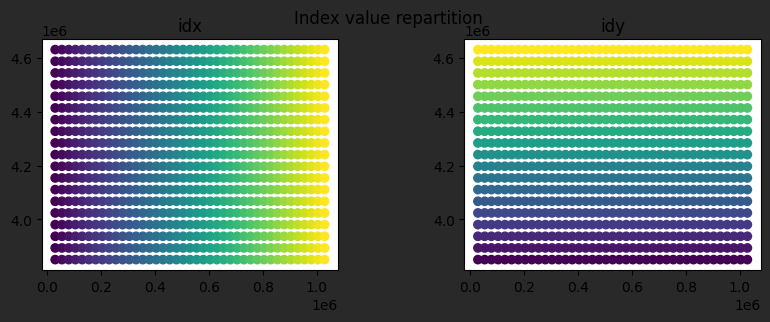

In [50]:
# TEST are my indexes behaving the way they're expected to
columns = ['idx', 'idy']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3), facecolor=(0.16,0.16,0.16))
[mesh_gdf.plot(ax=axes[i], column=columns[i]) for i in range(0,2)]   # comprehension list
[axes[i].set_title('{}'.format(columns[i]))for i in range(0,2)]                   # comprehension list
fig.suptitle('Index value repartition');

I expected idx values to continuously vary along the x axis, while remaining the same from row to row. Meanwhile, I expected idy to behave the other way around. Hence I'm satisfied with the results.

Also, take a notice at the density of points in the GeoDataFrame.

### Equidistant point mesh

I'm picking point which idx index is even *and* idy index is even *as well as* (***or*** status) odd idx's **and** odd idy's.

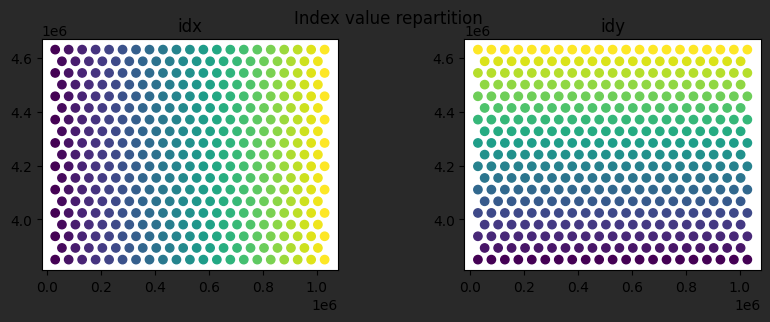

In [51]:
# evens = mesh_gdf[(mesh_gdf['idy'] % 2 == 0)&(mesh_gdf['idx'] % 2 == 0)] # TEST
oddsandevens = mesh_gdf[(mesh_gdf['idy'] % 2 == 0)&(mesh_gdf['idx'] % 2 == 0) | (mesh_gdf['idy'] % 2 == 1)&(mesh_gdf['idx'] % 2 == 1)].copy()

columns = ['idx', 'idy']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3), facecolor=(0.16,0.16,0.16))
[oddsandevens.plot(ax=axes[i], column=columns[i]) for i in range(0,2)]
[axes[i].set_title('{}'.format(columns[i])) for i in range(0,2)]
fig.suptitle('Index value repartition');

### Selection of useful points

In [52]:
# calclating the buffer
buffer = layer.buffer(5*a).unary_union  # seems more optimized than buffer = layer.unary_union.buffer(2*a)
layer_buffer = gpd.GeoDataFrame(geometry=[buffer], crs=layer.crs)
# layer_buffer  # TEST

# selection by localisation
tri = gpd.sjoin(oddsandevens,layer_buffer, predicate='intersects', how='inner')
tri.drop(columns='index_right', inplace=True)  #grooming

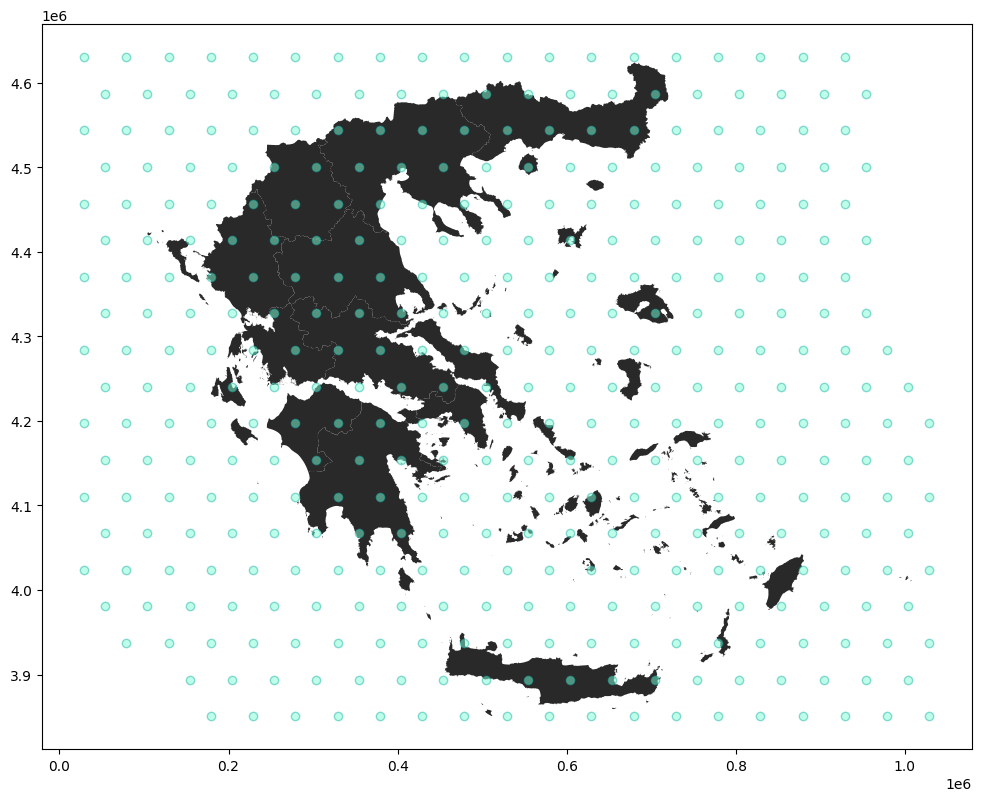

In [53]:
basemap = layer.plot(figsize=(12,12), facecolor=(0.16,0.16,0.16))
tri.plot(ax=basemap, color='aquamarine', edgecolor='lightseagreen', alpha=0.5);

## Voronois

We're going from a geometrycollection to gettin a full-featured Pandas GeoDataFrame

### Voronoi Creation

Now is the time to use [Shapely](https://shapely.readthedocs.io/en/stable/index.html)'s [Voronoi Polygons](https://shapely.readthedocs.io/en/stable/reference/shapely.voronoi_polygons.html) method. Shapely is supplied when the GeoPandas package is installing.


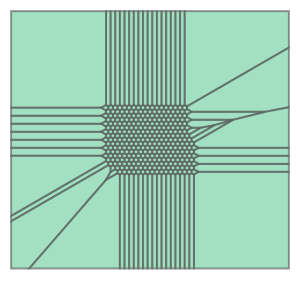

In [54]:
voronoi = shp.voronoi_polygons(tri.unary_union)
voronoi # it is a geometrycollection at this point

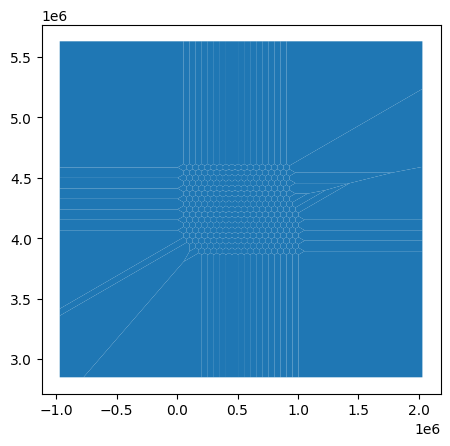

In [55]:
voronoi_df = gpd.GeoDataFrame(geometry=[voronoi])  # [voronoi] is a list
voronoi_df["geometries"] = voronoi_df.apply(lambda row: [g for g in row.geometry.geoms], axis=1)
voronoi_df.plot();

Notice the coordinate match our layer's CRS. But to this point, Shapely's Voronoi output is considered "naive geometry", though it is now encapsulated in a GeoDataFrame. We thus need to declare explicitly its refercence system. You'd also need to specify *inplace=True* so that the declaration is effectively implemented on the GeoDataFrame.

In [56]:
voronoi_df.drop(columns='geometries', inplace=True)
voronoi_df.set_crs(layer.crs, inplace=True)

,geometry
0,GEOMETRYCOLLECTION (POLYGON ((4011.353 4067317...


### Exploding this multipolygon into as many polygons

I want as many rows in my GeoDataFrame as there are cells in the geometry. [Explode() method](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explode.html) is the cure.

The method does preserve CRS declaration, hence no need to declare a CRS there. CRS mismatch can indeed cause issues with GeoPanda's [clipping method](https://geopandas.org/en/stable/docs/reference/api/geopandas.clip.html#geopandas.clip).

In [57]:
exploded_df = voronoi_df.explode(index_parts=True)
exploded_df.columns  # TEST

Index(['geometry'], dtype='object')

## Trimming

### Polygon Clipping

If I kept cells that are on top of coastal area without [clipping](https://geopandas.org/en/stable/docs/reference/api/geopandas.clip.html#geopandas.clip) them to the shore line, I'd have erroneous numbers in my spatial interpolation since there would be no way to differentiate the "NO DATA" part ouf our study -missing or unreliable figures- with the "NO DATA" as data that is outside of the studied area.

In [58]:
hex_clip = gpd.clip(gdf=exploded_df, mask=layer, keep_geom_type=False)
hex_clip.head()   # TEST

geometry
0 103  MULTIPOLYGON (((292290.555 4089417.858, 292300...
  93   MULTIPOLYGON (((304011.353 4125052.377, 304011...
  74   MULTIPOLYGON (((234153.559 4126802.749, 234191...
  104  POLYGON ((279011.353 4168353.647, 304011.353 4...
  150  MULTIPOLYGON (((404011.353 4107200.218, 404012...

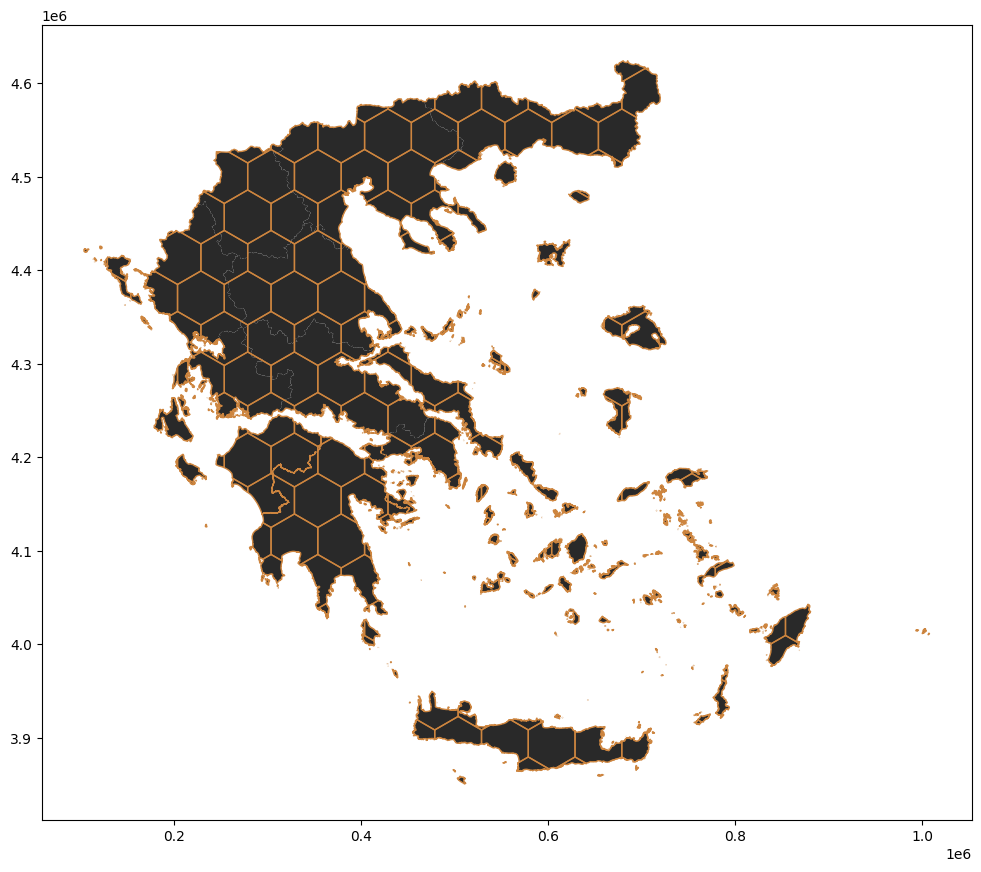

In [59]:
basemap = layer.plot(figsize=(12,12), facecolor=(0.16,0.16,0.16), zorder=1)
# basemap = tri.plot(ax=basemap, facecolor='slategrey',alpha = 0.5, zorder=3)
hex_clip.plot(ax=basemap, facecolor='none', ec='peru', zorder=2);

## Un-buffered greece: Creating a bounding box geodataframe


from a bit of help from the [envelope](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.envelope.html)which returns a geoseries.In turn this allows us to creating a [geodataframe](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html).


<Axes: >

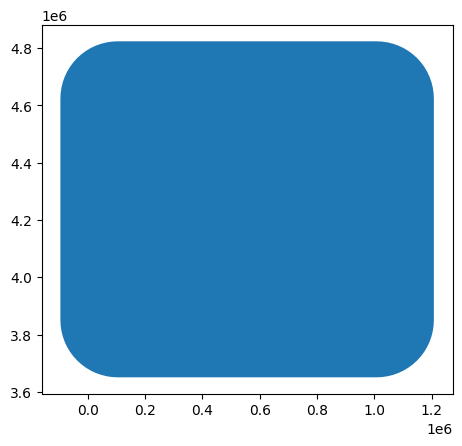

In [60]:
layer_envelope = layer.unary_union.envelope.buffer(4*a)
# layer_envelope # TEST
layer_envelope_df = gpd.GeoDataFrame(geometry=[layer_envelope], crs=layer.crs)
layer_envelope_df.plot()

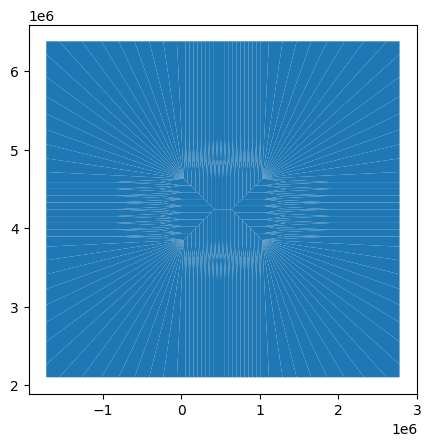

In [61]:
voronoi_andevens = shp.voronoi_polygons(oddsandevens.unary_union)  # don't buffer here

voronoi_andevens  # it is a geometrycollection at this point
voronoi_andevens_df = gpd.GeoDataFrame(geometry=[voronoi_andevens]).buffer(5*a)  # [voronoi] is a list
voronoi_andevens_df["geometries"] = voronoi_andevens_df.apply(lambda row: [g for g in row.geometry.geoms], axis=1)
voronoi_andevens_df.plot();

In [62]:
voronoi_andevens_df.columns

Index(['geometry', 'geometries'], dtype='object')

In [63]:
# voronoi_andevens_df.drop(columns='geometries', inplace=True)
voronoi_andevens_df.set_crs(layer.crs, inplace=True)
exploded_andevens_df = voronoi_andevens_df.explode(index_parts=True)
exploded_andevens_df.head()


geometries  \
0 0  [POLYGON ((-852406.2506445217 3894112.26937630...   
  1  [POLYGON ((-852406.2506445217 3894112.26937630...   
  2  [POLYGON ((-852406.2506445217 3894112.26937630...   
  3  [POLYGON ((-852406.2506445217 3894112.26937630...   
  4  [POLYGON ((-852406.2506445217 3894112.26937630...   

                                              geometry  
0 0  POLYGON ((-852406.251 3894112.269, 829.984 393...  
  1  POLYGON ((-1720988.647 3894112.269, -852406.25...  
  2  POLYGON ((829.984 3852195.461, -852406.251 389...  
  3  POLYGON ((-1720988.647 3980714.810, -852406.25...  
  4  POLYGON ((829.984 3938798.001, -852406.251 398...

In [64]:
# voronoi_df.drop(columns='geometries', inplace=True)

# exploded_andevens_df.drop(columns='geometry', inplace=True)


In [65]:
exploded_andevens_df.set_crs(layer.crs, inplace=True)


geometries  \
0 0    [POLYGON ((-852406.2506445217 3894112.26937630...   
  1    [POLYGON ((-852406.2506445217 3894112.26937630...   
  2    [POLYGON ((-852406.2506445217 3894112.26937630...   
  3    [POLYGON ((-852406.2506445217 3894112.26937630...   
  4    [POLYGON ((-852406.2506445217 3894112.26937630...   
...                                                  ...   
  291  [POLYGON ((-852406.2506445217 3894112.26937630...   
  292  [POLYGON ((-852406.2506445217 3894112.26937630...   
  293  [POLYGON ((-852406.2506445217 3894112.26937630...   
  294  [POLYGON ((-852406.2506445217 3894112.26937630...   
  295  [POLYGON ((-852406.2506445217 3894112.26937630...   

                                                geometry  
0 0    POLYGON ((-852406.251 3894112.269, 829.984 393...  
  1    POLYGON ((-1720988.647 3894112.269, -852406.25...  
  2    POLYGON ((829.984 3852195.461, -852406.251 389...  
  3    POLYGON ((-1720988.647 3980714.810, -852406.25...  
  4    POLYGON ((829.984 3938798.001, -852406.251 398...  
...                                                  ...  
  291  POLYGON ((2779011.353 4500330.052, 1910428.956...  
  292  POLYGON ((1057192.722 4545015.784, 1339772.890...  
  293  POLYGON ((1339772.890 4586932.592, 1057192.722...  
  294  POLYGON ((2779011.353 4716205.850, 1037599.455...  
  295  POLYGON ((2779011.353 4586932.592, 1910428.956...  

[296 rows x 2 columns]

In [66]:
exploded_andevens_df

geometries  \
0 0    [POLYGON ((-852406.2506445217 3894112.26937630...   
  1    [POLYGON ((-852406.2506445217 3894112.26937630...   
  2    [POLYGON ((-852406.2506445217 3894112.26937630...   
  3    [POLYGON ((-852406.2506445217 3894112.26937630...   
  4    [POLYGON ((-852406.2506445217 3894112.26937630...   
...                                                  ...   
  291  [POLYGON ((-852406.2506445217 3894112.26937630...   
  292  [POLYGON ((-852406.2506445217 3894112.26937630...   
  293  [POLYGON ((-852406.2506445217 3894112.26937630...   
  294  [POLYGON ((-852406.2506445217 3894112.26937630...   
  295  [POLYGON ((-852406.2506445217 3894112.26937630...   

                                                geometry  
0 0    POLYGON ((-852406.251 3894112.269, 829.984 393...  
  1    POLYGON ((-1720988.647 3894112.269, -852406.25...  
  2    POLYGON ((829.984 3852195.461, -852406.251 389...  
  3    POLYGON ((-1720988.647 3980714.810, -852406.25...  
  4    POLYGON ((829.984 3938798.001, -852406.251 398...  
...                                                  ...  
  291  POLYGON ((2779011.353 4500330.052, 1910428.956...  
  292  POLYGON ((1057192.722 4545015.784, 1339772.890...  
  293  POLYGON ((1339772.890 4586932.592, 1057192.722...  
  294  POLYGON ((2779011.353 4716205.850, 1037599.455...  
  295  POLYGON ((2779011.353 4586932.592, 1910428.956...  

[296 rows x 2 columns]

In [67]:
exploded_andevens_df.set_geometry('geometries', inplace=True)

TypeError: Input must be valid geometry objects: [<POLYGON ((-852406.251 3894112.269, 829.984 3936029.078, -281750.184 3894112...>, <POLYGON ((-1720988.647 3894112.269, -852406.251 3894112.269, 829.984 385219...>, <POLYGON ((829.984 3852195.461, -852406.251 3894112.269, -281750.184 3894112...>, <POLYGON ((-1720988.647 3980714.81, -852406.251 3980714.81, 829.984 3938798....>, <POLYGON ((829.984 3938798.001, -852406.251 3980714.81, -281750.184 3980714....>, <POLYGON ((-1720988.647 4067317.35, -852406.251 4067317.35, 829.984 4025400....>, <POLYGON ((-852406.251 3980714.81, 829.984 4022631.618, -281750.184 3980714....>, <POLYGON ((-1720988.647 4153919.891, -852406.251 4153919.891, 829.984 411200...>, <POLYGON ((-1720988.647 4240522.431, -852406.251 4240522.431, 829.984 419860...>, <POLYGON ((829.984 4025400.542, -852406.251 4067317.35, -281750.184 4067317....>, <POLYGON ((-1720988.647 4327124.971, -852406.251 4327124.971, 829.984 428520...>, <POLYGON ((-852406.251 4067317.35, 829.984 4109234.158, -281750.184 4067317....>, <POLYGON ((-1720988.647 4413727.512, -852406.251 4413727.512, 829.984 437181...>, <POLYGON ((-1720988.647 4500330.052, -852406.251 4500330.052, 829.984 445841...>, <POLYGON ((829.984 4628849.401, 20423.251 4630655.769, 24920.397 4630840.699...>, <POLYGON ((-1720988.647 4716205.85, 20423.251 4630655.769, 829.984 4628849.4...>, <POLYGON ((-1720988.647 4586932.592, -852406.251 4586932.592, 829.984 454501...>, <POLYGON ((-1720988.647 4889821.841, 24920.397 4630840.699, 20423.251 463065...>, <POLYGON ((26649.577 3850219.405, 24920.397 3850204.163, 20423.251 3850389.0...>, <POLYGON ((-1720988.647 3591223.021, 24920.397 3850204.163, 26649.577 385021...>, <POLYGON ((-1720988.647 3764839.012, 20423.251 3850389.093, 24920.397 385020...>, <POLYGON ((829.984 4112003.082, -852406.251 4153919.891, -281750.184 4153919...>, <POLYGON ((15846.928 3937413.54, 829.984 3938798.001, -281750.184 3980714.81...>, <POLYGON ((-852406.251 4153919.891, 829.984 4195836.699, -281750.184 4153919...>, <POLYGON ((829.984 4198605.623, -852406.251 4240522.431, -281750.184 4240522...>, <POLYGON ((-852406.251 4240522.431, 829.984 4282439.239, -281750.184 4240522...>, <POLYGON ((829.984 4025400.542, -281750.184 4067317.35, 829.984 4109234.158,...>, <POLYGON ((829.984 4285208.163, -852406.251 4327124.971, -281750.184 4327124...>, <POLYGON ((15846.928 4110618.62, 829.984 4112003.082, -281750.184 4153919.89...>, <POLYGON ((15846.928 4197221.161, 829.984 4198605.623, -281750.184 4240522.4...>, <POLYGON ((-852406.251 4327124.971, 829.984 4369041.78, -281750.184 4327124....>, <POLYGON ((829.984 4371810.703, -852406.251 4413727.512, -281750.184 4413727...>, <POLYGON ((15846.928 4283823.701, 829.984 4285208.163, -281750.184 4327124.9...>, <POLYGON ((-852406.251 4413727.512, 829.984 4455644.32, -281750.184 4413727....>, <POLYGON ((829.984 4458413.244, -852406.251 4500330.052, -281750.184 4500330...>, <POLYGON ((15846.928 4370426.241, 829.984 4371810.703, -281750.184 4413727.5...>, <POLYGON ((-852406.251 4500330.052, 829.984 4542246.86, -281750.184 4500330....>, <POLYGON ((829.984 4545015.784, -852406.251 4586932.592, -281750.184 4586932...>, <POLYGON ((15846.928 4457028.782, 829.984 4458413.244, -281750.184 4500330.0...>, <POLYGON ((-852406.251 4586932.592, 829.984 4628849.401, -281750.184 4586932...>, <POLYGON ((-1720988.647 5068586.043, 26649.577 4630825.457, 24920.397 463084...>, <POLYGON ((-1720988.647 2801901.365, 28271.811 3850367.735, 28469.472 385040...>, <POLYGON ((-1720988.647 3412458.819, 26649.577 3850219.405, 27496.274 385026...>, <POLYGON ((-1720988.647 3224650.987, 27496.274 3850268.895, 27974.608 385032...>, <POLYGON ((-1720988.647 3023122.641, 27974.608 3850320.655, 28271.811 385036...>, <POLYGON ((-1720988.647 6216341.408, 28607.827 4630599.597, 28469.472 463063...>, <POLYGON ((-1720988.647 5928122.319, 28469.472 4630635.749, 28271.811 463067...>, <POLYGON ((-1720988.647 5457922.22, 27974.608 4630724.207, 27496.274 4630775...>, <POLYGON ((-1720988.647 5256393.875, 27496.274 4630775.967, 26649.577 463082...>, <POLYGON ((-1720988.647 2100810.999, -1720988.647 2264703.453, 28607.827 385...>, <POLYGON ((-1720988.647 5679143.497, 28271.811 4630677.127, 27974.608 463072...>, <POLYGON ((-1268877.103 6380233.863, 28784.385 4630539.893, 28708.603 463056...>, <POLYGON ((-1557096.193 2100810.999, 28708.603 3850476.966, 28784.385 385050...>, <POLYGON ((-1720988.647 2552922.543, 28469.472 3850409.113, 28607.827 385044...>, <POLYGON ((-1019898.281 6380233.863, 28842.876 4630514.948, 28784.385 463053...>, <POLYGON ((-1720988.647 6380233.863, -1557096.193 6380233.863, 28708.603 463...>, <POLYGON ((-798677.005 6380233.863, 28889.01 4630492.534, 28842.876 4630514....>, <POLYGON ((-1268877.103 2100810.999, 28784.385 3850504.969, 28842.876 385052...>, <POLYGON ((-1019898.281 2100810.999, 28842.876 3850529.913, 28889.01 3850552...>, <POLYGON ((-597148.659 6380233.863, 28926.066 4630472.223, 28889.01 4630492....>, <POLYGON ((-798677.005 2100810.999, 28889.01 3850552.328, 28926.066 3850572....>, <POLYGON ((-409340.828 6380233.863, 28910.475 4630636.589, 28926.483 4630471...>, <POLYGON ((-597148.659 2100810.999, 28926.066 3850572.639, 28926.483 3850572...>, <POLYGON ((28910.475 3850408.273, 28926.483 3850572.895, 79011.353 3897053.3...>, <POLYGON ((28926.483 4630471.967, 28910.475 4630636.589, 28890.916 4631045.7...>, <POLYGON ((-409340.828 2100810.999, 28910.475 3850408.273, 28890.916 3849999...>, <POLYGON ((-230576.625 6380233.863, 28890.916 4631045.784, 28910.475 4630636...>, <POLYGON ((-230576.625 2100810.999, 28890.916 3849999.077, 28893.28 3848407....>, <POLYGON ((-56960.634 6380233.863, 28893.28 4632637.298, 28890.916 4631045.7...>, <POLYGON ((-56960.634 2100810.999, 28893.28 3848407.563, 35026.773 3728364.3...>, <POLYGON ((54011.353 6380233.863, 54011.353 5139120.553, 35026.773 4752680.5...>, <POLYGON ((104011.353 6380233.863, 104011.353 5139120.553, 85026.773 4752680...>, <POLYGON ((79011.353 4634948.199, 85026.773 4752680.557, 104011.353 4880664....>, <POLYGON ((54011.353 2100810.999, 54011.353 3341924.309, 72995.932 3728364.3...>, <POLYGON ((85026.773 3728364.304, 79011.353 3846096.663, 79011.353 3897053.3...>, <POLYGON ((54011.353 5139120.553, 72995.932 4752680.557, 54011.353 4880664.1...>, <POLYGON ((35026.773 4752680.557, 54011.353 5139120.553, 54011.353 4880664.1...>, <POLYGON ((54011.353 3341924.309, 54011.353 3600380.664, 72995.932 3728364.3...>, <POLYGON ((54011.353 3341924.309, 35026.773 3728364.304, 54011.353 3600380.6...>, <POLYGON ((154011.353 6380233.863, 154011.353 5139120.553, 135026.773 475268...>, <POLYGON ((104011.353 2100810.999, 104011.353 3341924.309, 122995.932 372836...>, <POLYGON ((135026.773 3728364.304, 129011.353 3846096.663, 129011.353 394867...>, <POLYGON ((129011.353 4634948.199, 135026.773 4752680.557, 154011.353 488066...>, <POLYGON ((104011.353 5139120.553, 122995.932 4752680.557, 104011.353 488066...>, <POLYGON ((85026.773 4752680.557, 104011.353 5139120.553, 104011.353 4880664...>, <POLYGON ((104011.353 3341924.309, 104011.353 3600380.664, 122995.932 372836...>, <POLYGON ((104011.353 3341924.309, 85026.773 3728364.304, 104011.353 3600380...>, <POLYGON ((179011.353 4634948.199, 185026.773 4752680.557, 204011.353 488066...>, <POLYGON ((204011.353 6380233.863, 204011.353 5139120.553, 185026.773 475268...>, <POLYGON ((154011.353 2100810.999, 154011.353 3341924.309, 172995.932 372836...>, <POLYGON ((185026.773 3728364.304, 179011.353 3846096.663, 179011.353 399766...>, <POLYGON ((154011.353 5139120.553, 172995.932 4752680.557, 154011.353 488066...>, <POLYGON ((135026.773 4752680.557, 154011.353 5139120.553, 154011.353 488066...>, <POLYGON ((154011.353 3341924.309, 154011.353 3600380.664, 172995.932 372836...>, <POLYGON ((154011.353 3341924.309, 135026.773 3728364.304, 154011.353 360038...>, <POLYGON ((204011.353 2100810.999, 204011.353 3341924.309, 222995.932 372836...>, <POLYGON ((254011.353 6380233.863, 254011.353 5139120.553, 235026.773 475268...>, <POLYGON ((204011.353 5139120.553, 222995.932 4752680.557, 204011.353 488066...>, <POLYGON ((185026.773 4752680.557, 204011.353 5139120.553, 204011.353 488066...>, <POLYGON ((235026.773 3728364.304, 229011.353 3846096.663, 229011.353 404782...>, <POLYGON ((204011.353 3341924.309, 204011.353 3341924.309, 204011.353 360038...>, <POLYGON ((229011.353 4634948.199, 235026.773 4752680.557, 254011.353 488066...>, <POLYGON ((204011.353 3341924.309, 185026.773 3728364.304, 204011.353 360038...>, <POLYGON ((279011.353 3846096.663, 279011.353 4098442.695, 289883.728 411061...>, <POLYGON ((254011.353 2100810.999, 254011.353 3341924.309, 272995.932 372836...>, <POLYGON ((279011.353 4382602.167, 279011.353 4634948.199, 285026.773 475268...>, <POLYGON ((254011.353 5139120.553, 272995.932 4752680.557, 254011.353 488066...>, <POLYGON ((235026.773 4752680.557, 254011.353 5139120.553, 254011.353 488066...>, <POLYGON ((254011.353 3341924.309, 254011.353 3600380.664, 272995.932 372836...>, <POLYGON ((304011.353 6380233.863, 304011.353 5139120.553, 285026.773 475268...>, <POLYGON ((254011.353 3341924.309, 235026.773 3728364.304, 254011.353 360038...>, <POLYGON ((304011.353 2100810.999, 304011.353 3341924.309, 322995.932 372836...>, <POLYGON ((304011.353 5139120.553, 322995.932 4752680.557, 304011.353 488066...>, <POLYGON ((285026.773 4752680.557, 304011.353 5139120.553, 304011.353 488066...>, <POLYGON ((335026.773 3728364.304, 329011.353 3846096.663, 329011.353 414756...>, <POLYGON ((304011.353 3341924.309, 304011.353 3600380.664, 322995.932 372836...>, <POLYGON ((329011.353 4634948.199, 335026.773 4752680.557, 354011.353 488066...>, <POLYGON ((354011.353 6380233.863, 354011.353 5139120.553, 335026.773 475268...>, <POLYGON ((304011.353 3341924.309, 285026.773 3728364.304, 304011.353 360038...>, <POLYGON ((354011.353 2100810.999, 354011.353 3341924.309, 372995.932 372836...>, <POLYGON ((354011.353 5139120.553, 372995.932 4752680.557, 354011.353 488066...>, <POLYGON ((335026.773 4752680.557, 354011.353 5139120.553, 354011.353 488066...>, <POLYGON ((354011.353 3341924.309, 354011.353 3600380.664, 372995.932 372836...>, <POLYGON ((354011.353 3341924.309, 335026.773 3728364.304, 354011.353 360038...>, <POLYGON ((385026.773 3728364.304, 379011.353 3846096.663, 379011.353 419901...>, <POLYGON ((404011.353 6380233.863, 404011.353 5139120.553, 385026.773 475268...>, <POLYGON ((379011.353 4634948.199, 385026.773 4752680.557, 404011.353 488066...>, <POLYGON ((404011.353 2100810.999, 404011.353 3341924.309, 422995.932 372836...>, <POLYGON ((404011.353 5139120.553, 422995.932 4752680.557, 404011.353 488066...>, <POLYGON ((385026.773 4752680.557, 404011.353 5139120.553, 404011.353 488066...>, <POLYGON ((404011.353 3341924.309, 404011.353 3600380.664, 422995.932 372836...>, <POLYGON ((404011.353 3341924.309, 385026.773 3728364.304, 404011.353 360038...>, <POLYGON ((454011.353 6380233.863, 454011.353 5139120.553, 435026.773 475268...>, <POLYGON ((429011.353 4634948.199, 435026.773 4752680.557, 454011.353 488066...>, <POLYGON ((435026.773 3728364.304, 429011.353 3846096.663, 429011.353 424052...>, <POLYGON ((454011.353 2100810.999, 454011.353 3341924.309, 472995.932 372836...>, <POLYGON ((454011.353 5139120.553, 472995.932 4752680.557, 454011.353 488066...>, <POLYGON ((435026.773 4752680.557, 454011.353 5139120.553, 454011.353 488066...>, <POLYGON ((454011.353 3341924.309, 454011.353 3600380.664, 472995.932 372836...>, <POLYGON ((454011.353 3341924.309, 435026.773 3728364.304, 454011.353 360038...>, <POLYGON ((504011.353 6380233.863, 504011.353 5139120.553, 504011.353 513912...>, <POLYGON ((479011.353 4634948.199, 485026.773 4752680.557, 504011.353 488066...>, <POLYGON ((485026.773 3728364.304, 479011.353 3846096.663, 479011.353 424052...>, <POLYGON ((504011.353 2100810.999, 504011.353 3341924.309, 522995.932 372836...>, <POLYGON ((504011.353 5139120.553, 504011.353 5139120.553, 522995.932 475268...>, <POLYGON ((485026.773 4752680.557, 504011.353 5139120.553, 504011.353 488066...>, <POLYGON ((504011.353 3341924.309, 504011.353 3600380.664, 522995.932 372836...>, <POLYGON ((504011.353 3341924.309, 485026.773 3728364.304, 504011.353 360038...>, <POLYGON ((529011.353 4634948.199, 535026.773 4752680.557, 554011.353 488066...>, <POLYGON ((554011.353 6380233.863, 554011.353 5139120.553, 535026.773 475268...>, <POLYGON ((529011.353 4240522.431, 579011.353 4240522.431, 579011.353 384609...>, <POLYGON ((554011.353 5139120.553, 572995.932 4752680.557, 554011.353 488066...>, <POLYGON ((535026.773 4752680.557, 554011.353 5139120.553, 554011.353 488066...>, <POLYGON ((554011.353 3341924.309, 535026.773 3728364.304, 554011.353 360038...>, <POLYGON ((554011.353 3341924.309, 554011.353 3600380.664, 572995.932 372836...>, <POLYGON ((554011.353 2100810.999, 554011.353 3341924.309, 572995.932 372836...>, <POLYGON ((579011.353 4634948.199, 585026.773 4752680.557, 604011.353 488066...>, <POLYGON ((604011.353 6380233.863, 604011.353 5139120.553, 585026.773 475268...>, <POLYGON ((579011.353 4240522.431, 629011.353 4240522.431, 629011.353 384609...>, <POLYGON ((604011.353 5139120.553, 622995.932 4752680.557, 604011.353 488066...>, <POLYGON ((585026.773 4752680.557, 604011.353 5139120.553, 604011.353 488066...>, <POLYGON ((604011.353 3341924.309, 585026.773 3728364.304, 604011.353 360038...>, <POLYGON ((604011.353 3341924.309, 604011.353 3600380.664, 622995.932 372836...>, <POLYGON ((604011.353 2100810.999, 604011.353 3341924.309, 622995.932 372836...>, <POLYGON ((629011.353 4634948.199, 635026.773 4752680.557, 654011.353 488066...>, <POLYGON ((654011.353 6380233.863, 654011.353 5139120.553, 635026.773 475268...>, <POLYGON ((629011.353 4240522.431, 636340.685 4240522.431, 679011.353 419901...>, <POLYGON ((654011.353 5139120.553, 672995.932 4752680.557, 654011.353 488066...>, <POLYGON ((635026.773 4752680.557, 654011.353 5139120.553, 654011.353 488066...>, <POLYGON ((654011.353 3341924.309, 635026.773 3728364.304, 654011.353 360038...>, <POLYGON ((654011.353 3341924.309, 654011.353 3600380.664, 672995.932 372836...>, <POLYGON ((654011.353 2100810.999, 654011.353 3341924.309, 672995.932 372836...>, <POLYGON ((679011.353 4634948.199, 685026.773 4752680.557, 704011.353 488066...>, <POLYGON ((704011.353 6380233.863, 704011.353 5139120.553, 685026.773 475268...>, <POLYGON ((729011.353 4147560.695, 681018.653 4197221.161, 1042175.778 41972...>, <POLYGON ((681018.653 4197221.161, 729011.353 4147560.695, 729011.353 384609...>, <POLYGON ((704011.353 5139120.553, 722995.932 4752680.557, 704011.353 488066...>, <POLYGON ((685026.773 4752680.557, 704011.353 5139120.553, 704011.353 488066...>, <POLYGON ((681018.653 4197221.161, 679011.353 4199016.467, 636340.685 424052...>, <POLYGON ((704011.353 3341924.309, 685026.773 3728364.304, 704011.353 360038...>, <POLYGON ((704011.353 3341924.309, 704011.353 3600380.664, 722995.932 372836...>, <POLYGON ((704011.353 2100810.999, 704011.353 3341924.309, 722995.932 372836...>, <POLYGON ((729011.353 4634948.199, 735026.773 4752680.557, 754011.353 488066...>, <POLYGON ((754011.353 6380233.863, 754011.353 5139120.553, 735026.773 475268...>, <POLYGON ((779011.353 4098442.695, 768138.978 4110618.62, 1042175.778 411061...>, <POLYGON ((768138.978 4110618.62, 779011.353 4098442.695, 779011.353 3846096...>, <POLYGON ((754011.353 5139120.553, 772995.932 4752680.557, 754011.353 488066...>, <POLYGON ((735026.773 4752680.557, 754011.353 5139120.553, 754011.353 488066...>, <POLYGON ((754011.353 3341924.309, 735026.773 3728364.304, 754011.353 360038...>, <POLYGON ((754011.353 3341924.309, 754011.353 3600380.664, 772995.932 372836...>, <POLYGON ((754011.353 2100810.999, 754011.353 3341924.309, 772995.932 372836...>, <POLYGON ((779011.353 4634948.199, 785026.773 4752680.557, 804011.353 488066...>, <POLYGON ((804011.353 6380233.863, 804011.353 5139120.553, 785026.773 475268...>, <POLYGON ((829011.353 4047821.613, 855317.329 4024016.08, 879011.353 3997669...>, <POLYGON ((785026.773 3728364.304, 779011.353 3846096.663, 779011.353 409844...>, <POLYGON ((804011.353 5139120.553, 822995.932 4752680.557, 804011.353 488066...>, <POLYGON ((785026.773 4752680.557, 804011.353 5139120.553, 804011.353 488066...>, <POLYGON ((804011.353 3341924.309, 785026.773 3728364.304, 804011.353 360038...>, <POLYGON ((804011.353 3341924.309, 804011.353 3600380.664, 822995.932 372836...>, <POLYGON ((804011.353 2100810.999, 804011.353 3341924.309, 822995.932 372836...>, <POLYGON ((829011.353 4634948.199, 835026.773 4752680.557, 854011.353 488066...>, <POLYGON ((854011.353 6380233.863, 854011.353 5139120.553, 835026.773 475268...>, <POLYGON ((942295.282 3937413.54, 929011.353 3948675.949, 879011.353 3997669...>, <POLYGON ((929011.353 3948675.949, 942295.282 3937413.54, 979011.353 3897053...>, <POLYGON ((854011.353 5139120.553, 872995.932 4752680.557, 854011.353 488066...>, <POLYGON ((835026.773 4752680.557, 854011.353 5139120.553, 854011.353 488066...>, <POLYGON ((854011.353 3341924.309, 835026.773 3728364.304, 854011.353 360038...>, <POLYGON ((854011.353 3341924.309, 854011.353 3600380.664, 872995.932 372836...>, <POLYGON ((854011.353 2100810.999, 854011.353 3341924.309, 872995.932 372836...>, <POLYGON ((879011.353 4634948.199, 885026.773 4752680.557, 904011.353 488066...>, <POLYGON ((904011.353 6380233.863, 904011.353 5139120.553, 885026.773 475268...>, <POLYGON ((1030526.432 3850268.895, 1030048.098 3850320.655, 1029750.895 385...>, <POLYGON ((2779011.353 3023122.641, 1030048.098 3850320.655, 1030526.432 385...>, <POLYGON ((885026.773 3728364.304, 879011.353 3846096.663, 879011.353 399766...>, <POLYGON ((904011.353 5139120.553, 922995.932 4752680.557, 904011.353 488066...>, <POLYGON ((885026.773 4752680.557, 904011.353 5139120.553, 904011.353 488066...>, <POLYGON ((904011.353 3341924.309, 885026.773 3728364.304, 904011.353 360038...>, <POLYGON ((904011.353 3341924.309, 904011.353 3600380.664, 922995.932 372836...>, <POLYGON ((904011.353 2100810.999, 904011.353 3341924.309, 922995.932 372836...>, <POLYGON ((929011.353 4634948.199, 935026.773 4752680.557, 954011.353 488066...>, <POLYGON ((954011.353 6380233.863, 954011.353 5139120.553, 935026.773 475268...>, <POLYGON ((2779011.353 2100810.999, 2615118.899 2100810.999, 1029314.103 385...>, <POLYGON ((954011.353 5139120.553, 972995.932 4752680.557, 954011.353 488066...>, <POLYGON ((935026.773 4752680.557, 954011.353 5139120.553, 954011.353 488066...>, <POLYGON ((2779011.353 5928122.319, 1029553.233 4630635.749, 1029414.879 463...>, <POLYGON ((1029414.879 4630599.597, 1029553.233 4630635.749, 1029750.895 463...>, <POLYGON ((954011.353 3341924.309, 935026.773 3728364.304, 954011.353 360038...>, <POLYGON ((954011.353 3341924.309, 954011.353 3600380.664, 972995.932 372836...>, <POLYGON ((954011.353 2100810.999, 954011.353 3341924.309, 972995.932 372836...>, <POLYGON ((979011.353 4634948.199, 985026.773 4752680.557, 1004011.353 48806...>, <POLYGON ((1004011.353 6380233.863, 1004011.353 5139120.553, 985026.773 4752...>, <POLYGON ((1655171.365 2100810.999, 1029096.639 3850572.639, 1029133.695 385...>, <POLYGON ((985026.773 3728364.304, 979011.353 3846096.663, 979011.353 389705...>, <POLYGON ((1004011.353 5139120.553, 1022995.932 4752680.557, 1004011.353 488...>, <POLYGON ((985026.773 4752680.557, 1004011.353 5139120.553, 1004011.353 4880...>, <POLYGON ((2326899.809 6380233.863, 1029238.32 4630539.893, 1029179.829 4630...>, <POLYGON ((1004011.353 3341924.309, 985026.773 3728364.304, 1004011.353 3600...>, <POLYGON ((1004011.353 3341924.309, 1004011.353 3600380.664, 1022995.932 372...>, <POLYGON ((1004011.353 2100810.999, 1004011.353 3341924.309, 1022995.932 372...>, <POLYGON ((1288599.331 6380233.863, 1029131.79 4631045.784, 1029129.426 4632...>, <POLYGON ((1114983.34 6380233.863, 1029129.426 4632637.298, 1022995.932 4752...>, <POLYGON ((1655171.365 6380233.863, 1029096.639 4630472.223, 1029096.223 463...>, <POLYGON ((1114983.34 2100810.999, 1029129.426 3848407.563, 1029131.79 38499...>, <POLYGON ((1856699.711 6380233.863, 1029133.695 4630492.534, 1029096.639 463...>, <POLYGON ((1288599.331 2100810.999, 1029131.79 3849999.077, 1029112.23 38504...>, <POLYGON ((1467363.533 6380233.863, 1029112.23 4630636.589, 1029131.79 46310...>, <POLYGON ((1467363.533 2100810.999, 1029112.23 3850408.273, 1029096.223 3850...>, <POLYGON ((1856699.711 2100810.999, 1029133.695 3850552.328, 1029179.829 385...>, <POLYGON ((2779011.353 6380233.863, 2779011.353 6216341.408, 1029414.879 463...>, <POLYGON ((2077920.987 6380233.863, 1029179.829 4630514.948, 1029133.695 463...>, <POLYGON ((2077920.987 2100810.999, 1029179.829 3850529.913, 1029238.32 3850...>, <POLYGON ((2779011.353 5068586.043, 1031373.128 4630825.457, 1030526.432 463...>, <POLYGON ((2326899.809 2100810.999, 1029238.32 3850504.969, 1029314.103 3850...>, <POLYGON ((2615118.899 6380233.863, 1029314.103 4630567.895, 1029238.32 4630...>, <POLYGON ((2779011.353 2264703.453, 1029414.879 3850445.265, 1029553.233 385...>, <POLYGON ((2779011.353 2552922.543, 1029553.233 3850409.113, 1029750.895 385...>, <POLYGON ((2779011.353 5679143.497, 1029750.895 4630677.127, 1029553.233 463...>, <POLYGON ((2779011.353 2801901.365, 1029750.895 3850367.735, 1030048.098 385...>, <POLYGON ((2779011.353 5457922.22, 1030048.098 4630724.207, 1029750.895 4630...>, <POLYGON ((2779011.353 3224650.987, 1030526.432 3850268.895, 1031373.128 385...>, <POLYGON ((2779011.353 5256393.875, 1030526.432 4630775.967, 1030048.098 463...>, <POLYGON ((855317.329 4457028.782, 879011.353 4483374.99, 929011.353 4532368...>, <POLYGON ((2779011.353 3412458.819, 1031373.128 3850219.405, 1033102.309 385...>, <POLYGON ((768138.978 4370426.241, 779011.353 4382602.167, 829011.353 443322...>, <POLYGON ((2779011.353 4889821.841, 1033102.309 4630840.699, 1031373.128 463...>, <POLYGON ((1057192.722 3852195.461, 1339772.89 3894112.269, 1910428.956 3894...>, <POLYGON ((1339772.89 3894112.269, 1057192.722 3936029.078, 1910428.956 3894...>, <POLYGON ((681018.653 4283823.701, 729011.353 4333484.166, 768138.978 437042...>, <POLYGON ((2779011.353 3894112.269, 1910428.956 3894112.269, 1057192.722 393...>, <POLYGON ((1057192.722 3938798.001, 1339772.89 3980714.81, 1910428.956 39807...>, <POLYGON ((1339772.89 3980714.81, 1057192.722 4022631.618, 1910428.956 39807...>, <POLYGON ((2779011.353 3980714.81, 1910428.956 3980714.81, 1057192.722 40226...>, <POLYGON ((1057192.722 4025400.542, 1339772.89 4067317.35, 1910428.956 40673...>, <POLYGON ((1339772.89 4067317.35, 1057192.722 4109234.158, 1910428.956 40673...>, <POLYGON ((1339772.89 4413727.512, 1057192.722 4455644.32, 1910428.956 44137...>, <POLYGON ((2779011.353 3591223.021, 1033102.309 3850204.163, 1037599.455 385...>, <POLYGON ((2779011.353 4067317.35, 1910428.956 4067317.35, 1057192.722 41092...>, <POLYGON ((2779011.353 3764839.012, 1037599.455 3850389.093, 1057192.722 385...>, <POLYGON ((1057192.722 4112003.082, 1339772.89 4153919.891, 1910428.956 4153...>, <POLYGON ((1339772.89 4153919.891, 1057192.722 4195836.699, 1910428.956 4153...>, <POLYGON ((2779011.353 4153919.891, 1910428.956 4153919.891, 1057192.722 419...>, <POLYGON ((1057192.722 4198605.623, 1339772.89 4240522.431, 1910428.956 4240...>, <POLYGON ((1339772.89 4240522.431, 1057192.722 4282439.239, 1910428.956 4240...>, <POLYGON ((2779011.353 4240522.431, 1910428.956 4240522.431, 1057192.722 428...>, <POLYGON ((1057192.722 4285208.163, 1339772.89 4327124.971, 1910428.956 4327...>, <POLYGON ((1339772.89 4327124.971, 1057192.722 4369041.78, 1910428.956 43271...>, <POLYGON ((2779011.353 4327124.971, 1910428.956 4327124.971, 1057192.722 436...>, <POLYGON ((1057192.722 4371810.703, 1339772.89 4413727.512, 1910428.956 4413...>, <POLYGON ((2779011.353 4413727.512, 1910428.956 4413727.512, 1057192.722 445...>, <POLYGON ((1057192.722 4458413.244, 1339772.89 4500330.052, 1910428.956 4500...>, <POLYGON ((1339772.89 4500330.052, 1057192.722 4542246.86, 1910428.956 45003...>, <POLYGON ((2779011.353 4500330.052, 1910428.956 4500330.052, 1057192.722 454...>, <POLYGON ((1057192.722 4545015.784, 1339772.89 4586932.592, 1910428.956 4586...>, <POLYGON ((1339772.89 4586932.592, 1057192.722 4628849.401, 1910428.956 4586...>, <POLYGON ((2779011.353 4716205.85, 1037599.455 4630655.769, 1033102.309 4630...>, <POLYGON ((2779011.353 4586932.592, 1910428.956 4586932.592, 1057192.722 462...>]

In [68]:
#clipping
exploded_andevens_clip = gpd.clip(gdf=exploded_andevens_df, mask=layer_envelope_df, keep_geom_type=False)

In [69]:
exploded_andevens_clip_df = gpd.GeoDataFrame(data=exploded_andevens_clip, crs=layer.crs)
exploded_andevens_clip_df

geometries  \
0 95   [POLYGON ((-852406.2506445217 3894112.26937630...   
  143  [POLYGON ((-852406.2506445217 3894112.26937630...   
  104  [POLYGON ((-852406.2506445217 3894112.26937630...   
  111  [POLYGON ((-852406.2506445217 3894112.26937630...   
  127  [POLYGON ((-852406.2506445217 3894112.26937630...   
...                                                  ...   
  165  [POLYGON ((-852406.2506445217 3894112.26937630...   
  157  [POLYGON ((-852406.2506445217 3894112.26937630...   
  192  [POLYGON ((-852406.2506445217 3894112.26937630...   
  173  [POLYGON ((-852406.2506445217 3894112.26937630...   
  201  [POLYGON ((-852406.2506445217 3894112.26937630...   

                                                geometry  
0 95   POLYGON ((222995.932 3728364.304, 229011.353 3...  
  143  POLYGON ((522995.932 3728364.304, 529011.353 3...  
  104  POLYGON ((272995.932 3728364.304, 279011.353 3...  
  111  POLYGON ((322995.932 3728364.304, 329011.353 3...  
  127  POLYGON ((422995.932 3728364.304, 429011.353 3...  
...                                                  ...  
  165  POLYGON ((635026.773 4752680.557, 629011.353 4...  
  157  POLYGON ((585026.773 4752680.557, 579011.353 4...  
  192  POLYGON ((785026.773 4752680.557, 779011.353 4...  
  173  POLYGON ((685026.773 4752680.557, 679011.353 4...  
  201  POLYGON ((835026.773 4752680.557, 829011.353 4...  

[296 rows x 2 columns]

In [70]:
# selection by localisation
exploded_andevens_select = gpd.sjoin(exploded_andevens_df, layer_envelope_df, predicate='intersects', how='inner')
exploded_andevens_select.drop(columns='index_right', inplace=True)  #grooming

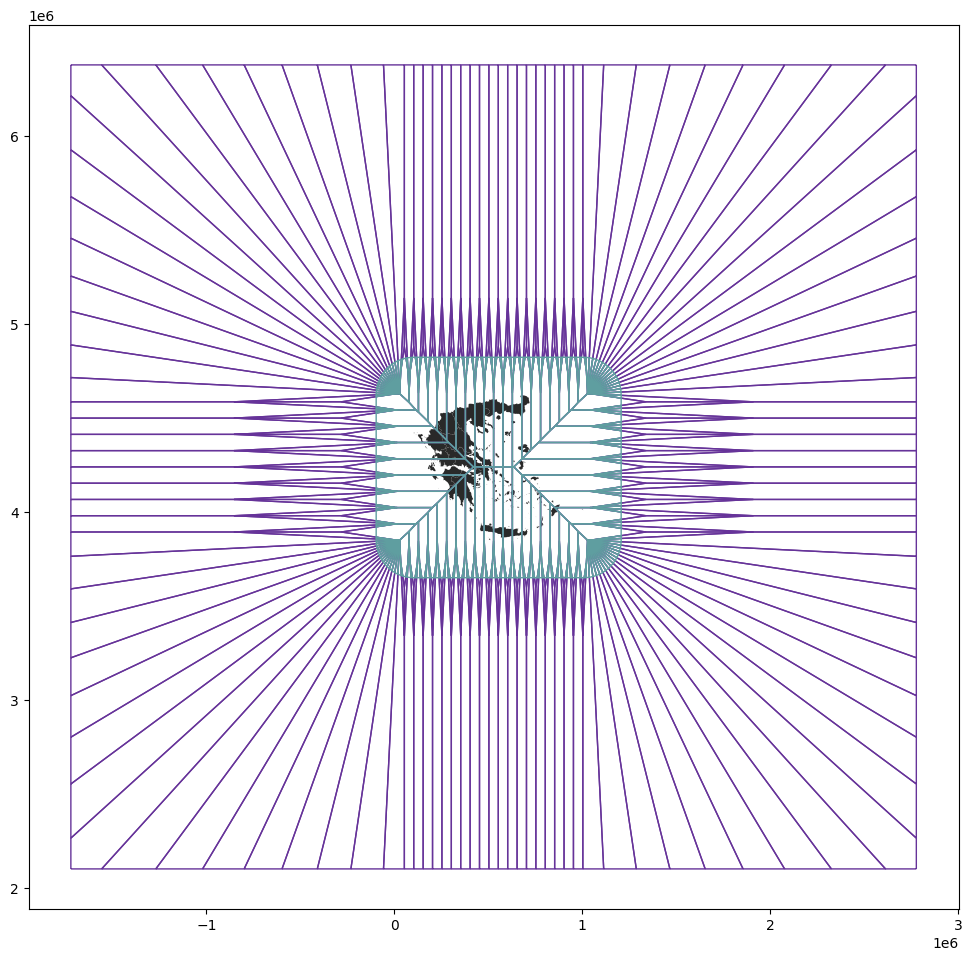

In [71]:
basemap = layer.plot(figsize=(12,12), facecolor=(0.16,0.16,0.16), zorder=1)
exploded_andevens_clip.plot(ax=basemap,facecolor='none', ec='cadetblue', zorder=3)
exploded_andevens_select.plot(ax=basemap,facecolor='none', ec='rebeccapurple', zorder=2);

### Export to Shapefile : make all of these guys a multipolygon

Notice we make are reusing our *a* parameter to name our file. I'm replacing files with the same name. These combined conventions are allowing me to run th script over and over without flooding my database and keep different scaled data in my database.

In [72]:
hex_clip['geometry']

0  103    MULTIPOLYGON (((292290.555 4089417.858, 292300...
   93     MULTIPOLYGON (((304011.353 4125052.377, 304011...
   74     MULTIPOLYGON (((234153.559 4126802.749, 234191...
   104    POLYGON ((279011.353 4168353.647, 304011.353 4...
   150    MULTIPOLYGON (((404011.353 4107200.218, 404012...
                                ...                        
   221    MULTIPOLYGON (((579011.353 4581719.906, 579015...
   240    POLYGON ((629011.353 4573090.683, 629019.439 4...
   259    POLYGON ((679011.353 4582375.145, 679039.869 4...
   241    POLYGON ((704011.353 4615800.106, 680392.374 4...
   260    MULTIPOLYGON (((714984.880 4609464.537, 715224...
Name: geometry, Length: 176, dtype: geometry

In [73]:
hex_clip_df = hex_clip['geometry'].explode(index_parts=True)


In [74]:
# creating an index

In [75]:
# importing to Shapefile
hex_clip['geometry'].to_file("hex_clip_{}.shp".format(a))
# hex_clip['geometry'].to_file("hex_clip_10000.shp")

## Sources

J'ai téléchargé un [shapefile](https://geodata.gov.gr/en/dataset/periphereies-elladas/resource/7c80a2c1-93b7-4814-9fc4-245e775acaa6) des régions administratives du site [GEODATA.gov.gr](GEODATA.gov.gr). Projection 2100, que ne lit pas QGIS. J'ai vérifié le décalage avec la carte du monde livrée avec QGIS (si on tape WORLD dans les coordonnées).